In [1]:
from uproot_io import Events, View
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

In [2]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\PandoraRecoFile_1.root")

In [67]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def inlierplot(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    particleType = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        
        particleType.append(pdg)
        
        if plot == True:
            plt.scatter(x, z, s=0.5)
                
        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 1000
        #inlier_threshold = 2.0
        
        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model
            gradients.append(m)
            intercepts.append(c)
            
            if plot == True:
                x_inliers = x[best_inliers]
                z_inliers = z[best_inliers]
                plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                plt.plot(x_inliers, m * x_inliers + c)
                plt.xlabel('x')
                plt.ylabel('w')
        
            perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
            num_points = int(0.5 * len(x))
            mean = np.mean(perp_dist[:num_points])
            #mean = np.mean(perp_dist)
            resis.append(mean)
        else:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
            #print("No inliers found for a particle")
            continue
    
    if plot == True:
        plt.show()
    
    return np.array(np.stack((gradients, intercepts, resis, particleType)))

In [49]:
def allresiduals():
    allnumber = []
    for i in np.unique(events.event_number):
        resid = inlierplot(i, False)
        allnumber.append(resid)
    return np.array(allnumber)
    

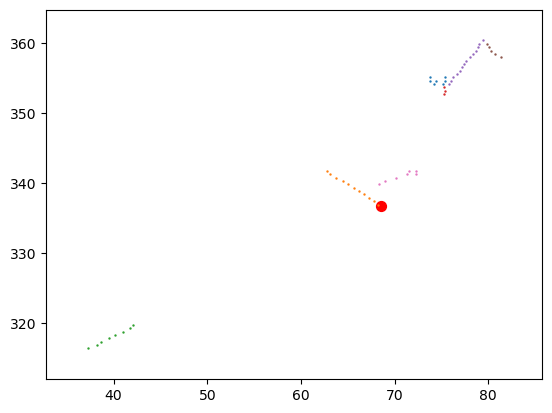

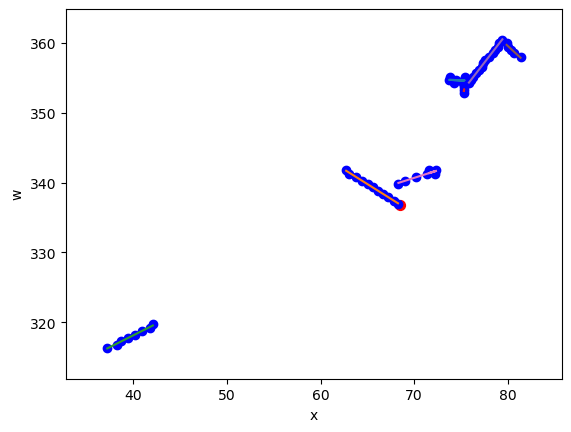

array([[-3.20468098e-02, -8.40309143e-01,  6.74388170e-01,
         8.99341774e+00,  1.73453534e+00, -1.23922980e+00,
         4.29110765e-01],
       [ 3.57044342e+02,  3.94396912e+02,  2.91156189e+02,
        -3.24087189e+02,  2.22753174e+02,  4.58662567e+02,
         3.10629822e+02],
       [ 3.25109792e-01,  2.77469682e-02,  5.77066936e-02,
         4.07807438e-02,  4.97827275e-02,  1.08960881e-01,
         7.17567855e-02],
       [ 2.20000000e+01,  2.21200000e+03,  2.20000000e+01,
         2.20000000e+01,  2.20000000e+01,  2.20000000e+01,
         0.00000000e+00]])

In [79]:
inlierplot(447, True)

In [97]:
import math

def coords(event_number):
    array = inlierplot(event_number, False)
    m = array[0, :]
    c = array[1, :]
    r = array[2, :]
    part = array[3, :]
    
    residuals = []
    
    #print(part)
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        if m[i] == 0 and c[i] == 0 and r[i] == 0:
            residuals.append(0)
            continue
        else:
            x = events.reco_hits_x_w[i+idx[0]]
            z = events.reco_hits_w[i+idx[0]]
            
            znew = z - c[i]

            angle = -math.atan(m[i])

            l = x * np.cos(angle) - znew * np.sin(angle)
            t = x * np.sin(angle) + znew * np.cos(angle)
            #plt.scatter(l,t)
            #plt.show()
            residuals.append(np.mean(abs(t)))
    
    residuals = np.array(residuals)
    return part, residuals

coords(22)

(array([-211.,  211., -211., 2212.,  211.,  211., 2212., 2212.,  211.,
         211.]),
 array([0.0932134 , 1.0753746 , 1.1517359 , 0.19365065, 0.33771014,
        0.04636792, 0.09482498, 0.0343132 , 2.2271144 , 1.5215999 ],
       dtype=float32))

In [140]:
#electron = +-11, photon = 22
#remember if residuals = 0, particle failed to fit

def histplot(num):
    tracks = []
    showers = []
    
    for n in range(num):
        part, res = coords(n)
        for i in range(len(res)):
            if res[i] == 0:
                continue        
            if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                showers.append(res[i]**2)
            else:
                tracks.append(res[i]**2)
        
    plt.hist(tracks, 50, density=True, alpha=0.8, label='Tracks')
    plt.hist(showers, 50, density=True, alpha=0.8, label='Showers')
    plt.legend()
    plt.show()
    
    n_bins = 20
    # Create the histogram for data1
    hist1, bin_edges = np.histogram(tracks, bins=n_bins)

    # Create the histogram for data2
    hist2, _ = np.histogram(showers, bins=bin_edges)

    # Calculate the bin widths
    bin_widths = np.diff(bin_edges)
    
    total_data1 = len(tracks)
    total_data2 = len(showers)
    hist1_normalized = hist1 / (total_data1 * bin_widths)
    hist2_normalized = hist2 / (total_data2 * bin_widths)

    # Plot the normalized histograms
    plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.5, label='Data 1')
    plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.5, label='Data 2')

    # Plot both histograms on the same plot
    #plt.bar(bin_edges[:-1], hist1, width=bin_widths, align='edge', alpha=0.5, label='Data 1')
    #plt.bar(bin_edges[:-1], hist2, width=bin_widths, align='edge', alpha=0.5, label='Data 2')

    # Add a legend to distinguish the two datasets
    plt.legend()

    # Show the plot
    plt.show()

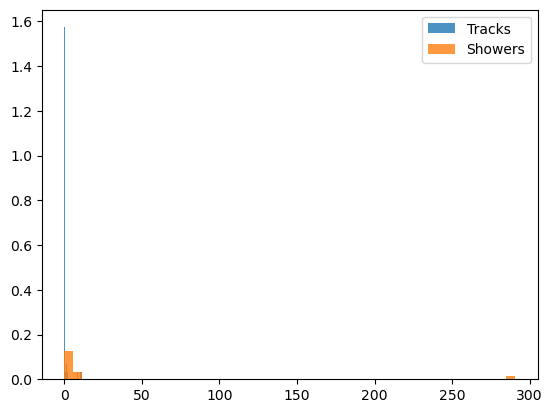

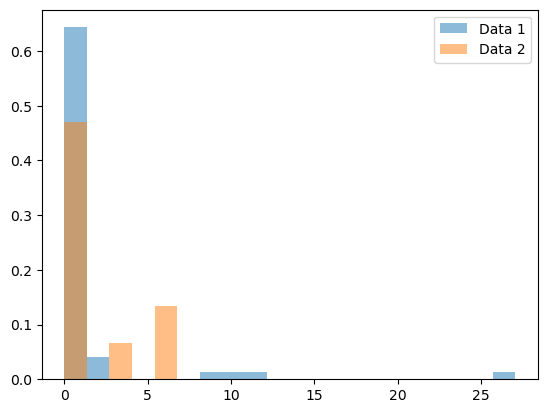

In [141]:
histplot(10)